In [ ]:
#For the purpose of downloading the dataset and using it(From Sanskar's Drive)
!gdown --id 1CwUQujWyIjG1I5G_MT9uWMWbrPXDZ2RE

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1CwUQujWyIjG1I5G_MT9uWMWbrPXDZ2RE
To: /content/e-shop.csv
100% 6.68M/6.68M [00:00<00:00, 30.9MB/s]


165474
B :
[2008    4    3    3   29 1012    1  131    6    5    2   62    1    2]
[ 2008     7    18    20    29 19917     4  1672    14     6     1    33
     2     4]
32580
The coresets are:
[[2008    7   18 ...   33    2    4]
 [2008    4    3 ...   62    1    2]
 [2008    7   18 ...   33    2    4]
 ...
 [2008    4    3 ...   62    1    2]
 [2008    4    3 ...   62    1    2]
 [2008    7   18 ...   33    2    4]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


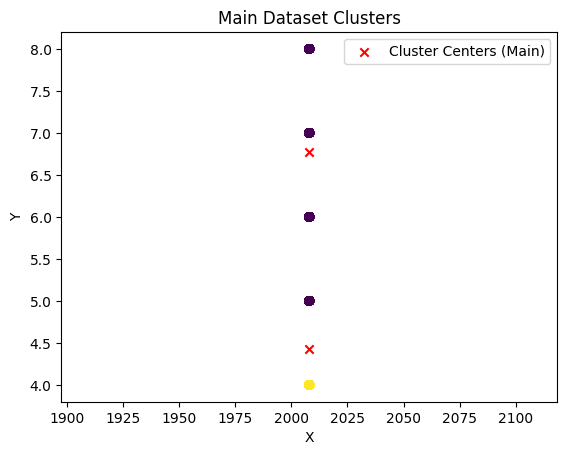

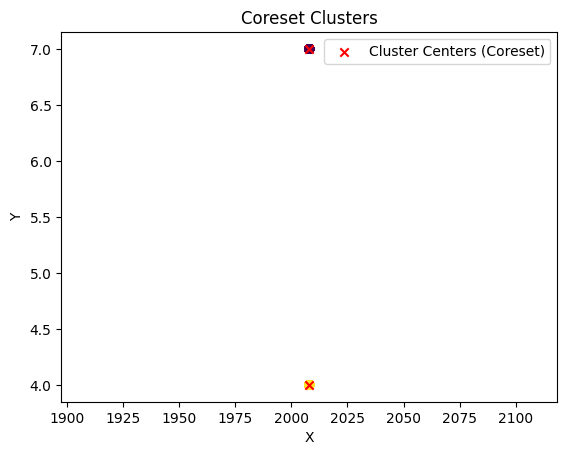

In [ ]:
#Algorithm 1 - D^2 sampling
import numpy as np
import pandas as pd
import math
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

alphabet_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}

#Reading the csv file
df = pd.read_csv('e-shop.csv', delimiter=';')

# Replace alphabets with numerical values in the 'page 2 (clothing model)' column
df['page 2 (clothing model)'] = df['page 2 (clothing model)'].apply(lambda x: ''.join(str(alphabet_mapping.get(c, c)) for c in x))

# Save the modified DataFrame back to a new CSV file
df.to_csv('modified_file.csv', index=False)

dataset = pd.read_csv('modified_file.csv').values

num_points = dataset.shape[0]
print(num_points)
probabilities = np.ones(num_points) / num_points


np.set_printoptions(precision=15)
probabilities /= np.sum(probabilities)


probabilities = np.asarray(probabilities).astype('float64')
probabilities = probabilities / np.sum(probabilities)


def iterative_sampling(dataset, weights, k, mu):
    num_points = dataset.shape[0]
    num_features = dataset.shape[1]
    B = []

    # Step 1: Randomly select an initial point
    initial_index = np.random.choice(num_points, p=weights)
    B.append(dataset[initial_index])

    # Step 2: Iterative sampling
    for _ in range(2, k+1):
        distances = np.min(euclidean_distances(dataset, B), axis=1)
        probabilities = distances**2 * mu

        # Normalize probabilities
        probabilities /= np.sum(probabilities)

        # Sample a new point
        sampled_index = np.random.choice(num_points, p=probabilities)
        B.append(dataset[sampled_index])

    # Return set B
    return B

k = 2  # Number of clusters
mu = 0.5  # Weighting parameter
weights = np.ones(dataset.shape[0])
weights /= np.sum(weights)
B = iterative_sampling(dataset, weights, k, mu)

print("B :")
for point in B:
    print(point)

# #Elbow method to find the desired k value for number of clusters


# def elbow_method(data, max_k):
#     sse = []
#     for k in range(1, max_k+1):
#         kmeans = KMeans(n_clusters=k, random_state=42)
#         kmeans.fit(data)
#         sse.append(kmeans.inertia_)  # Sum of squared distances to closest centroid

#     # Plot the SSE for each value of K
#     plt.plot(range(1, max_k+1), sse)
#     plt.xlabel('Number of Clusters (K)')
#     plt.ylabel('Sum of Squared Distances')
#     plt.title('Elbow Method')
#     plt.show()

# max_clusters = 5
# elbow_method(dataset, max_clusters)

#Algorithm 2 - Coreset Construction

import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
import math

def compute_quantization_error(X, centers):
    distances = np.min(euclidean_distances(X, centers), axis=1)
    return np.sum(distances)

def coreset_construction(X, k, B, m, epsilon, delta):
    alpha = 16 * (np.log(k) + 2)

    # Step 2: Compute sets Bi and c_phi
    sets_Bi = []
    # c_phi = 0
    for bi in B:
        Bi = X[np.argmin(euclidean_distances(X, [bi]), axis=0)]
        sets_Bi.append(Bi)
    distances = np.min(euclidean_distances(dataset, B), axis=1)
    c_phi =sum(distances)/num_points
    # c_phi /= len(X)

    # Step 3: Compute the sensitivities s(x)
    sensitivities = np.zeros(len(X))
    for i, bi in enumerate(B):
        Bi = sets_Bi[i]
        denominator = alpha * c_phi + 2 * alpha * np.sum(euclidean_distances(Bi, [bi]))
        for j, x in enumerate(Bi):
            numerator = alpha * euclidean_distances([x], [bi])[0] + 4 * len(X) / len(Bi)
            sensitivities[np.where((X == x).all(axis=1))] = numerator / denominator

    # Step 4: Compute the sampling probabilities p(x)
    sensitivity_sum = np.sum(sensitivities)
    if sensitivity_sum == 0:
        sampling_probabilities = np.ones(len(X)) / len(X)
    else:
        sampling_probabilities = sensitivities / sensitivity_sum

    # Step 5: Sample the coreset C
    C_indices = np.random.choice(np.arange(len(X)), size=m, replace=True, p=sampling_probabilities)
    C_weights = 1 / (m * sampling_probabilities[C_indices])
    C = X[C_indices]

    return C


X = dataset  # Assuming dataset is a pandas DataFrame
k = 2
epsilon = 0.2
delta = 0.1
d = X.shape[1]

# print(X.shape)
m = 15*math.ceil((d * k**3 * math.log(k) + k**2 * math.log(1 / delta) )/ epsilon**2)
print(m)
C = coreset_construction(X, k, B, m, epsilon, delta)
print("The coresets are:")
print(C)


#Cluster Visualization


# Assuming main dataset is stored in X and coreset is stored in C

# Perform K-means clustering on the main dataset
kmeans_main = KMeans(n_clusters=k, init='k-means++').fit(X)
labels_main = kmeans_main.labels_
centers_main = kmeans_main.cluster_centers_

# Perform K-means clustering on the coreset
kmeans_coreset = KMeans(n_clusters=k, init='k-means++').fit(C)
labels_coreset = kmeans_coreset.labels_
centers_coreset = kmeans_coreset.cluster_centers_

# Plotting the main dataset
plt.scatter(X[:, 0], X[:, 1], c=labels_main)
plt.scatter(centers_main[:, 0], centers_main[:, 1], marker='x', color='red', label='Cluster Centers (Main)')
plt.title('Main Dataset Clusters')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# Plotting the coreset
plt.scatter(C[:, 0], C[:, 1], c=labels_coreset)
plt.scatter(centers_coreset[:, 0], centers_coreset[:, 1], marker='x', color='red', label='Cluster Centers (Coreset)')
plt.title('Coreset Clusters')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()



In [ ]:
# print(C[-50:])
for x in C:
  if x[10]==2:
      print(x[10])


Streaming output truncated to the last 5000 lines.
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2

In [ ]:
import random
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances

# Reading the CSV file
df = pd.read_csv('e-shop.csv', delimiter=';')


alphabet_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


# Replace alphabets with numerical values in the 'page 2 (clothing model)' column
df['page 2 (clothing model)'] = df['page 2 (clothing model)'].apply(
    lambda x: ''.join(str(alphabet_mapping.get(c, c)) for c in x)
)

# Save the modified DataFrame back to a new CSV file
df.to_csv('modified_file.csv', index=False)

# Load the modified dataset from the CSV file
dataset = pd.read_csv('modified_file.csv').values

Si_set=[]
Hi_set=[]
Pi_set=[]
def INIT(P, m, noise_std):
    i = 1
    Pi = np.array(P, dtype=np.float64)  # Convert to float type
    S = set()

    while len(Pi) > m:
        Si_indices = random.sample(range(len(Pi)), m)
        Si = Pi[Si_indices]
        Si = [tuple(point) for point in Si]  # Convert points to tuples
        ci = random.uniform(1/4, 3/4)
        distances = euclidean_distances(Pi, Si)[:, 0]  # Compute distances from Pi to Si
        Hi_indices = sorted(range(len(Pi)), key=lambda k: distances[k])[:int(ci * len(Pi))]
        Hi = Pi[Hi_indices]
        Hi = [tuple(point) for point in Hi]  # Convert points to tuples
        Si_set.append(Si)
        S.update(Si)
        Pi = set(map(tuple, Pi)) - set(Hi)
        Pi = np.array(list(Pi), dtype=np.float64)
        Pi_set.append(Pi)
        # Add Gaussian noise to each point in Pi
        noise = np.random.normal(0, noise_std, size=Pi.shape)
        Pi += noise
        Hi_set.append(Hi)

        i += 1

    # Add Gaussian noise to remaining points in Pi
    noise = np.random.normal(0, noise_std, size=Pi.shape)
    Pi += noise

    S.update(map(tuple, Pi))

    return S

P = dataset
m = 100
noise_std = 1  # Standard deviation of Gaussian noise

# print()
x=INIT(P, m, noise_std)
k=len(x)
print(len(x))
for y in x:
    print(y)

print(len(x))


990
(2006.6549516596874, 11.561950041336745, 12.088926852298302, 0.83989461540997, 12.02142183458673, 23851.533108245894, 2.6799729551260216, 357.35719934363, 7.296915350035817, -0.5434825030027854, 1.5528253840995383, 54.09125135745528, 3.141393479760181, 4.525382761404525)
(2006.9170374234077, 5.0213145100661505, 2.730487721379156, 17.61788914064346, 30.589426479720988, 13167.066014556473, -0.10243433218644066, 334.2517619392214, 11.677166859312653, 6.9523247933549115, 4.797476083049595, 47.75582552804843, -0.6043174684094562, 1.9151689250735362)
(2006.9506348355417, 6.152784168881815, 10.749640634624686, 6.126434801631271, 21.02077024878727, 23861.082847313704, 3.329937722762917, 22.06291996782589, -2.4109148728076137, 2.9363728454303866, -3.9997786184146618, 50.55498246355791, -1.1675745103460502, 5.541330350548117)
(2008.362205726836, 5.498485234133341, 20.890220992226272, 0.2541860159398336, 8.817012301456264, 15491.415418252327, 0.17722695329203486, 131.8900038613101, 4.63284915

In [ ]:
import numpy as np
import math

Si_set2=Si_set
def reconstruct_levels(i, n):
    for j in range(i, n):
        Pi = np.array(Pi_set[j])
        data = np.array(list(Pi), dtype=np.float64)

        # Add Gaussian noise to each point in Pi
        noise = np.random.normal(0, noise_std, size=Pi.shape)
        data += noise

# Perform reconstruction
# reconstructed_data = reconstruct(data)
def replace_point_in_heap(heap, old_point, new_point):
    """
    Replaces occurrences of old_point with new_point in the heap.
    """
    indices = np.where(np.all(heap == old_point, axis=1))[0]
    # heap[indices] =
    for x in indices:
        heap[indices]=new_point


def MOVE(P, Pa, i):
    len_Hi = len(Hi_set)
    Si = np.array(Si_set[i])
    Hi = np.array(Hi_set[i])
    hi = np.max([np.linalg.norm(q - Si) for q in Si])

    if np.linalg.norm(Pa - P) > hi:
        MOVE(Pa, P, i + 1)
    elif any(np.array_equal(P, h) for h in Hi) and np.linalg.norm(Pa - P) <= np.linalg.norm(P - Si) / 2:
        return
    elif np.linalg.norm(P - Si) <= hi and np.linalg.norm(Pa - Si) <= hi:
        replace_point_in_heap(Hi, P, Pa)
        if P in Si:
            reconstruct_levels(i, len_Hi)
        return

    if np.linalg.norm(P - Si) <= hi:
        UPDATE(P, i, "delete")
        UPDATE(Pa, i, "insert")
    else:
        UPDATE(Pa, i, "delete")
        UPDATE(P, i, "insert")
    return


def UPDATESAMPLE(p, i, action):
    Pi = Pi_set[i]
    Si = Si_set[i]
    if action == 'insert':
        Pi = np.append(Pi, p)
    else:
        Pi = np.setdiff1d(Pi, p)
    r_p = np.random.uniform()
    Pi_prime = Pi[np.random.uniform(size=len(Pi)) <= k * np.log2(len(Pi)) / len(Pi)]
    Si = np.array(Pi_prime)
    Si_set[i] = Si
    return np.array_equal(Si, Si_set2[i])

def UPDATE(p, i, action):
    x1 = UPDATESAMPLE(p, i, action)
    if not x1:
        reconstruct_levels(i)
    # Rest of the code...

def BALANCE(i):
    Hi = Hi_set[i]
    Pi = Pi_set[i]
    Hd=np.arrray(Hi)-np.array(Pi)

    if len(Hi) / (len(Hi) + len(Hd)) < 1/4 or len(Hi) / (len(Hi) + len(Hd)) > 3/4:
        P = max(Hi, Hd, key=len)
        UPDATE(P, i, 'delete')
        UPDATE(P, i, 'insert')
    return

def RELAXATION(P, C, v):
    connected_centers = []
    for i in range(len(C)):
        pd = min(P, key=lambda p: np.linalg.norm(p - np.array(C[i])))
        P = np.setdiff1d(P, pd)
        temp_C = np.copy(C)
        temp_C[i] = pd
        r = compute_cost(temp_C,P)
        connected_centers.append((temp_C, r))
    return min(connected_centers, key=lambda x: x[1])


def compute_cost(centers, points):
    total_cost = 0

    for point in points:
        min_distance = math.inf

        for center in centers:
            distance = math.sqrt((point[0] - center[0])**2 + (point[1] - center[1])**2)
            min_distance = min(min_distance, distance)

        total_cost += min_distance

    return total_cost

print(Si_set)
for i in range(1):
    Si = Si_set[i]
    Si = np.array(Si)
    noise = np.random.normal(2, 2.5, size=Si.shape)
    Si2 = Si + noise

    # print(Si)
    # print(noise)
    print(Si.shape, Si2.shape)
    for j in range(len(Si)):
        MOVE(Si[j], Si2[j], i)
print(Si_set)

[[(2008.0, 4.0, 15.0, 1.0, 29.0, 3872.0, 4.0, 161.0, 3.0, 1.0, 1.0, 38.0, 1.0, 1.0), (2008.0, 4.0, 1.0, 10.0, 29.0, 201.0, 1.0, 140.0, 4.0, 2.0, 2.0, 38.0, 2.0, 3.0), (2008.0, 4.0, 2.0, 6.0, 24.0, 517.0, 1.0, 14.0, 3.0, 2.0, 2.0, 38.0, 2.0, 1.0), (2008.0, 4.0, 18.0, 2.0, 29.0, 4595.0, 1.0, 14.0, 3.0, 2.0, 2.0, 38.0, 2.0, 1.0), (2008.0, 8.0, 9.0, 33.0, 9.0, 23504.0, 1.0, 19.0, 3.0, 3.0, 1.0, 82.0, 1.0, 1.0), (2008.0, 6.0, 22.0, 6.0, 29.0, 15691.0, 4.0, 1612.0, 4.0, 4.0, 1.0, 33.0, 2.0, 1.0), (2008.0, 8.0, 5.0, 2.0, 29.0, 22881.0, 2.0, 223.0, 7.0, 2.0, 1.0, 38.0, 2.0, 2.0), (2008.0, 7.0, 24.0, 9.0, 9.0, 20896.0, 2.0, 24.0, 10.0, 2.0, 1.0, 52.0, 1.0, 1.0), (2008.0, 4.0, 4.0, 5.0, 29.0, 1467.0, 2.0, 211.0, 2.0, 4.0, 1.0, 43.0, 2.0, 1.0), (2008.0, 4.0, 28.0, 6.0, 29.0, 6401.0, 4.0, 164.0, 4.0, 2.0, 1.0, 38.0, 1.0, 1.0), (2008.0, 5.0, 26.0, 6.0, 29.0, 11166.0, 2.0, 214.0, 2.0, 5.0, 1.0, 62.0, 1.0, 1.0), (2008.0, 5.0, 18.0, 1.0, 29.0, 9838.0, 1.0, 110.0, 3.0, 4.0, 1.0, 38.0, 2.0, 1.0), (2008.

ValueError: ignored

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the dataset
dataset = pd.read_csv('modified_file.csv')  # Replace 'dataset.csv' with the path to your dataset

# Split the dataset into features (X) and labels (y)
X = dataset.drop('model photography', axis=1)  # Adjust the column name if necessary
y = dataset['model photography']               # Adjust the column name if necessary

# Split the dataset into training and testing sets
class_frequencies = dataset['model photography'].value_counts()

# Calculate inverse class frequencies
inverse_class_frequencies = 1 / class_frequencies

# Assign weights based on inverse class frequencies
sample_weights = dataset['model photography'].map(inverse_class_frequencies)
X_train, X_test1, y_train, y_test1,weights_train, weights_test = train_test_split(X, y,sample_weights, test_size=0.2, random_state=42)

# Display the sample weights
print(sample_weights)
# Create a logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train,sample_weight = weights_train)

# Make predictions on the testing set
y_pred = model.predict(X_test1)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test1, y_pred)
print("Accuracy:", accuracy)


0         0.000008
1         0.000008
2         0.000008
3         0.000023
4         0.000023
            ...   
165469    0.000008
165470    0.000008
165471    0.000008
165472    0.000008
165473    0.000023
Name: model photography, Length: 165474, dtype: float64
Accuracy: 0.7168756609759782


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the dataset


# Convert the list of tuples to a pandas DataFrame
dataset = pd.DataFrame(x)

# Remove the 11th column (index 10) from the dataset
X = dataset.drop(10, axis=1)

# Round off the values in the 10th column (label)
y = dataset[10].round()
# class_frequencies = y.value_counts()
# inverse_class_frequencies = 1 / class_frequencies
# sample_weights = y.map(inverse_class_frequencies)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = LogisticRegression()
# Train the model

model.fit(X_train, y_train,sample_weight = weights_train[:792])

# Make predictions on the testing set
y_pred = model.predict(X_test1)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test1, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7431636198821574


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the dataset

# Convert the list of lists to a NumPy array
dataset = np.array(C)

# Remove the 11th column (index 10) from the dataset
X = np.delete(dataset, 10, axis=1)

# Split the dataset into features (X) and labels (y)
y = dataset[:, 10]  # 11th column (index 10)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test1)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test1, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.540836984438737


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
